<a href="https://colab.research.google.com/github/5213478/mr1/blob/main/double_bijiao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/'

Mounted at /content/drive


In [ ]:
import joblib
data = joblib.load(root_path + 'Parallel network weight/data/rml_trainvaltest3.hdf5')

In [ ]:
!nvidia-smi

Sun Apr  9 15:48:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#%reset
#%tensorflow_version 1.x
import joblib
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
import math
import tensorflow as tf
from keras.metrics import categorical_accuracy
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add, ReLU, GRU, GlobalMaxPool2D,multiply, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.initializers import glorot_uniform, Constant
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers
from keras.layers import Lambda

import autograd.numpy as np
from autograd import grad

import keras.backend as K

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
EPOCHS = 100
NUM_CLASSES = 11
BATCH_SIZE = 1024 #time-series
PATIENCE = 10

In [ ]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
#ip--ap
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])#建立数组
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

In [ ]:
#设置混淆矩阵
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    #调制--索引
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size) #输入测试数据X,输出预测结果y_hat
    y_hat_onehot = np.zeros_like(y_hat) #其维度与矩阵y_hat一致，并为其初始化为全0
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels, rotation=45)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

In [ ]:
#created my own LabelBinarizer class so can encode both 2-class and multiclass cases
#建立分类函数
class MyLabelBinarizer(preprocessing.LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=2):
    # 如果通道在前，输入的类型不变
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + 'Parallel network weight/double CNN1/%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = MyLabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
  
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    # 有出处
    snr_ranges = [(-20, 18), (-10, 0), (1, 18)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    # unique函数去除其中重复的元素，并按元素由大到小返回一个新的无元素重复的元组或者列表
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]

      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("SNR (dB)")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()

    # acc--snr曲线图函数
  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

    # 
  def confmat_snr(self, snr_rng):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

In [ ]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['train', 'val', 'test'])
Train val test size:  (147400, 2, 128) (28600, 2, 128) (44000, 2, 128)
Check if data is shuffled:  [['QAM64' '12']
 ['QAM64' '-20']
 ['QAM64' '-20']
 ['CPFSK' '12']
 ['WBFM' '18']
 ['AM-DSB' '-20']
 ['PAM4' '-12']
 ['QAM64' '-4']
 ['PAM4' '12']
 ['QAM64' '10']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [7327 7467 7344 7417 7402 7428 7457 7344 7335 7355 7362 7329 7315 7407
 7362 7366 7483 7278 7306 7316]
Check modulation types:  ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']
Check distribution of samples across modulation types:  [13447 13432 13547 13458 13375 13356 13336 13320 13329 13403 13397]


In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 
y_train = labels_train[:,0]

X_val = data['val']['X']
labels_val = data['val']['labels'] 
y_val = labels_val[:,0]

X_test = data['test']['X']
labels_test = data['test']['labels'] 
y_test = labels_test[:,0]

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

In [ ]:
dr = 0.5
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

input_x = Input(shape=(1, X_test.shape[1],X_test.shape[2]))

input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

layer1 = Conv2D(100, (1, 8), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)
#layer1 = Dropout(dr)(layer1)
layer1 = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

layer2 = Conv2D(50, (2, 8), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
#layer2 = Dropout(dr)(layer2)
layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

layer3 = Conv2D(100, (1, 3), padding='valid', activation="relu", name="conv3", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
#layer3 = Dropout(dr)(layer3)

#concat = keras.layers.concatenate([layer1, layer3])

#concat_size = list(np.shape(concat))
#input_dim = int(concat_size[-1] * concat_size[-2])
#timesteps = int(concat_size[-3])
#concat = Reshape((timesteps, input_dim))(concat)

#gru_out = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(concat)
#layer_dense1 = Dense(256, activation='selu', kernel_initializer='he_normal', name="dense101")(gru_out)

#gru_out = Dropout(dr)(gru_out)

#gru_out = Reshape((1,50))(gru_out)

model1 = Model(inputs=input_x, outputs=layer3)

model1.compile()

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2, 128)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 1, 2, 132)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 100, 2, 125)       900       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 100, 2, 129)      0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 50, 1, 122)        80050     
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 50, 1, 126)       0     

In [ ]:
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])


input_x = Input(shape=(1, X_ap_test.shape[1], X_ap_test.shape[2]))

input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

layer1 = Conv2D(100, (1, 8), padding='valid', activation="relu", name="conv21", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)

#layer1 = Dropout(dr)(layer1)
layer1 = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

layer2 = Conv2D(50, (2, 8), padding="valid", activation="relu", name="conv22", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
#layer2 = Dropout(dr)(layer2)
layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

layer3 = Conv2D(100, (1, 3), padding='valid', activation="relu", name="conv23", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
#layer3 = Dropout(dr)(layer3)

#concat = keras.layers.concatenate([layer1, layer3])

#concat_size = list(np.shape(concat))
#input_dim = int(concat_size[-1] * concat_size[-2])
#timesteps = int(concat_size[-3])
#concat = Reshape((timesteps, input_dim))(concat)
#gru_out = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(concat)
#layer_dense1 = Dense(256, activation='selu', kernel_initializer='he_normal', name="dense101")(gru_out)

#gru_out = Dropout(dr)(gru_out)

#gru_out = Reshape((50,1))(gru_out)

model2 = Model(inputs=input_x, outputs=layer3)

model2.compile()

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 2, 128)]       0         
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 1, 2, 132)        0         
 ng2D)                                                           
                                                                 
 conv21 (Conv2D)             (None, 100, 2, 125)       900       
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 100, 2, 129)      0         
 ng2D)                                                           
                                                                 
 conv22 (Conv2D)             (None, 50, 1, 122)        80050     
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 50, 1, 126)       0   

In [ ]:
mergedOut = keras.layers.concatenate([model1.output,model2.output]) 
# output layer
mergedOut = Flatten()(mergedOut)
mergedOut = Dropout(dr)(mergedOut)
#mergedOut = GRU(100, activation='tanh', input_dim=input_dim, input_length=timesteps, return_sequences=True)(mergedOut)
#mergedOut = Dropout(dr)(mergedOut)
#mergedOut = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(mergedOut)
#mergedOut = Dropout(dr)(mergedOut)
#mergedOut = Dense(128, activation='selu')(mergedOut)
#mergedOut = Flatten()(mergedOut)
#mergedOut = Dropout(dr)(mergedOut)
mergedOut = Dense(11, activation='softmax')(mergedOut)
newModel = Model([model1.input,model2.input], mergedOut)
#newModel.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(lr=0.00018),metrics=['accuracy'])
#newModel.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
newModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#optimizer = AdamW()
#newModel.compile(loss='categorical_crossentropy',optimizer=adamw, metrics=['accuracy'])
newModel.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_39 (ZeroPadding  (None, 1, 2, 132)   0           ['input_14[0][0]']               
 2D)                                                                                              
                                                                                                  
 zero_padding2d_42 (ZeroPadding  (None, 1, 2, 132)   0           ['input_15[0][0]']        

In [ ]:
double_CNN_model_evaluater = ModelEvaluater(newModel, [X_train2,X_ap_train2], y_train, [X_val2,X_ap_val2], y_val, [X_test2,X_ap_test2], y_test, labels_test, BATCH_SIZE, 'double_CNN' )
double_CNN_model_evaluater.fit(EPOCHS, patience=PATIENCE)
#double_CNN_model_evaluater.print_summary()

y_train 147400
y_val 28600
y_test 44000
Epoch 1/100
144/144 [==============================] - ETA: 0s - loss: 1.8888 - accuracy: 0.3145
Epoch 1: val_loss improved from inf to 1.59801, saving model to /content/drive/My Drive/Parallel network weight/double CNN1/double_CNN-weights-1.hdf5
144/144 [==============================] - 17s 102ms/step - loss: 1.8888 - accuracy: 0.3145 - val_loss: 1.5980 - val_accuracy: 0.4249
Epoch 2/100
144/144 [==============================] - ETA: 0s - loss: 1.5157 - accuracy: 0.4510
Epoch 2: val_loss improved from 1.59801 to 1.42550, saving model to /content/drive/My Drive/Parallel network weight/double CNN1/double_CNN-weights-2.hdf5
144/144 [==============================] - 15s 102ms/step - loss: 1.5157 - accuracy: 0.4510 - val_loss: 1.4255 - val_accuracy: 0.4847
Epoch 3/100
144/144 [==============================] - ETA: 0s - loss: 1.4153 - accuracy: 0.4854
Epoch 3: val_loss improved from 1.42550 to 1.35874, saving model to /content/drive/My Drive/Paral

y_train 147400
y_val 28600
y_test 44000


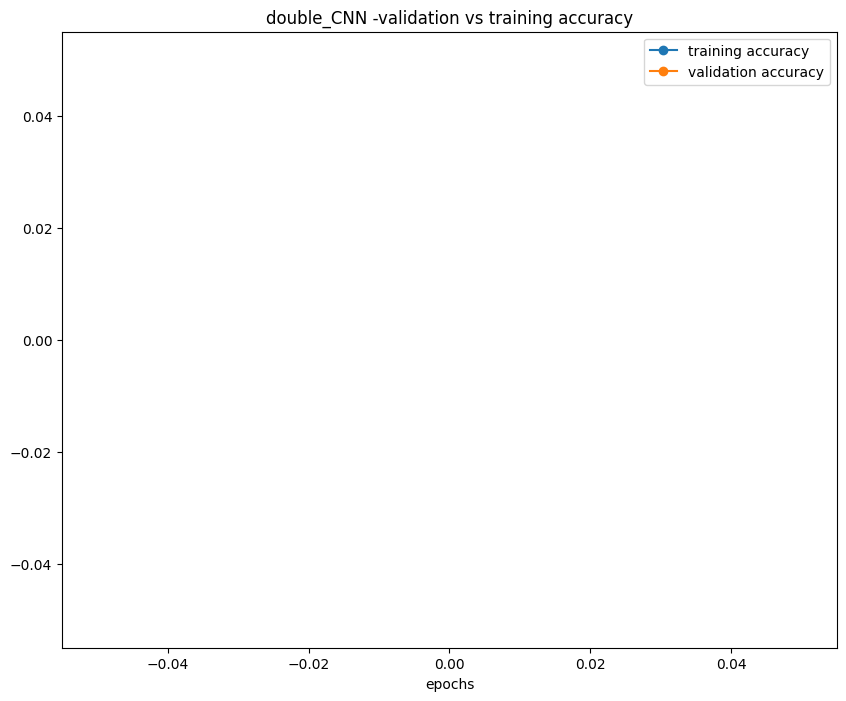

None

43/43 [==============================] - 1s 27ms/step


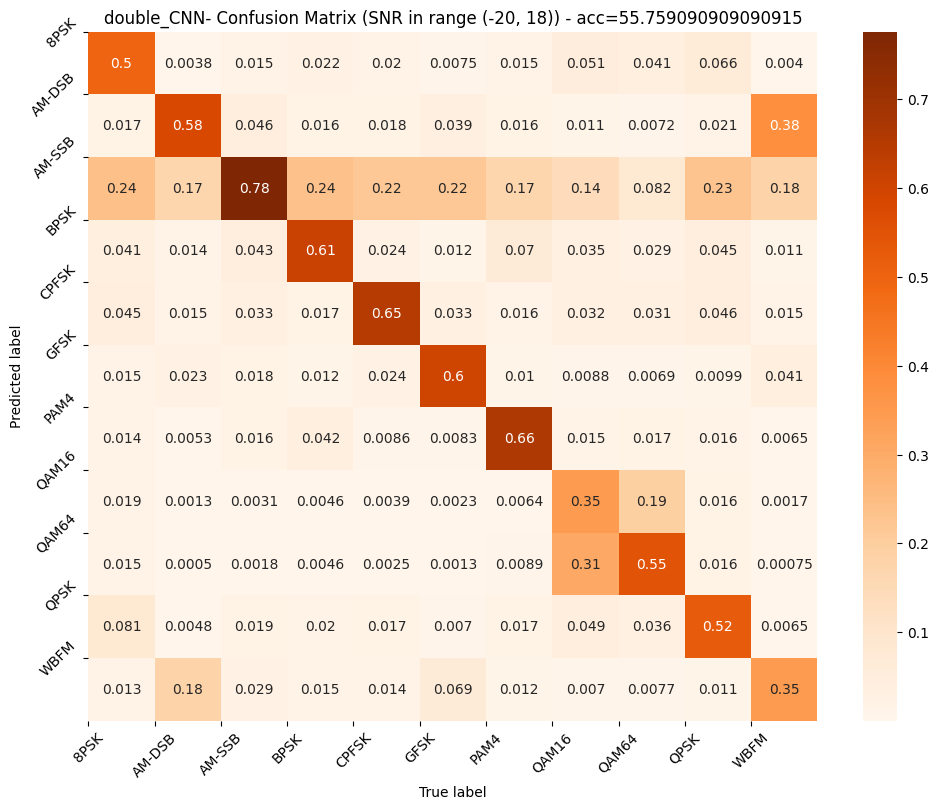

18/18 [==============================] - 0s 26ms/step


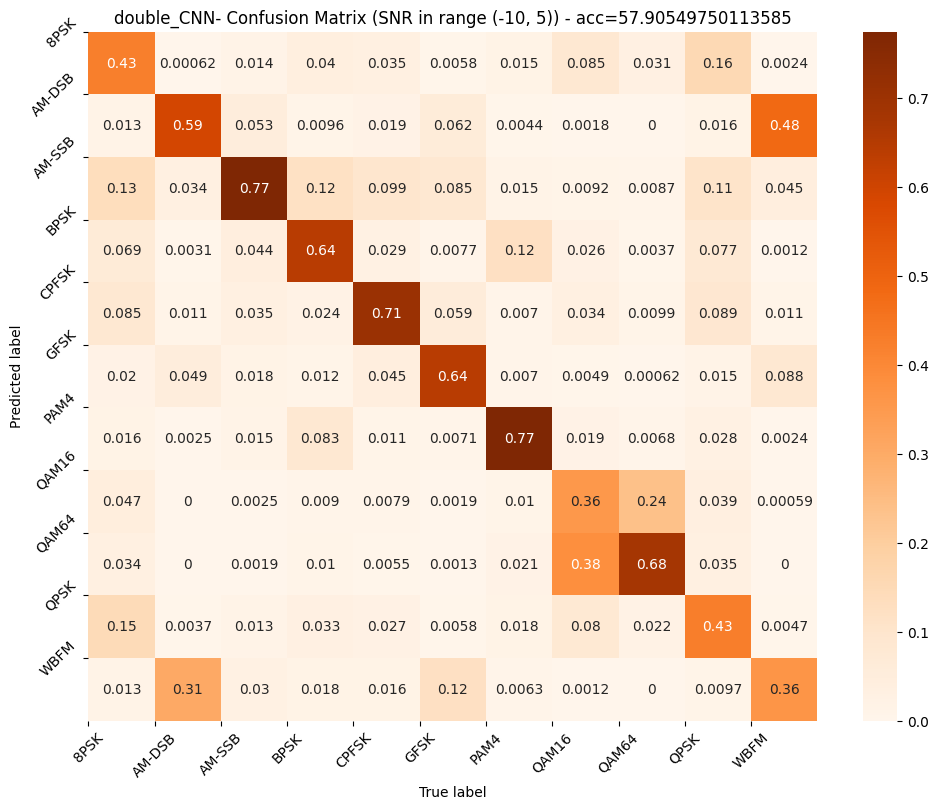

16/16 [==============================] - 0s 26ms/step


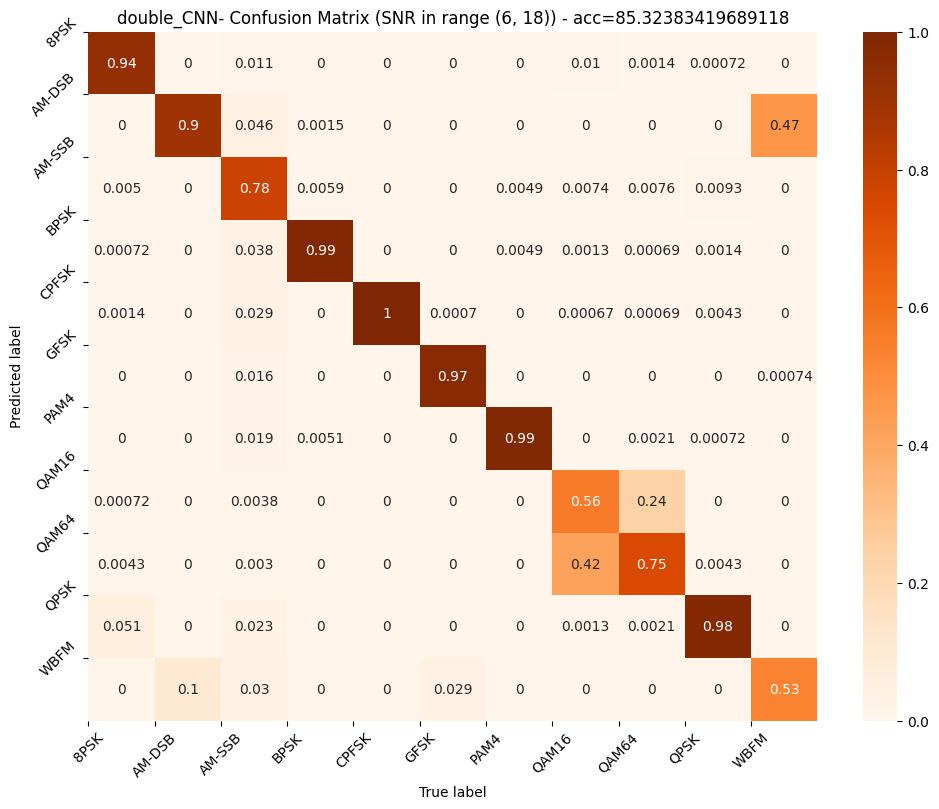

3/3 [==============================] - 0s 37ms/step


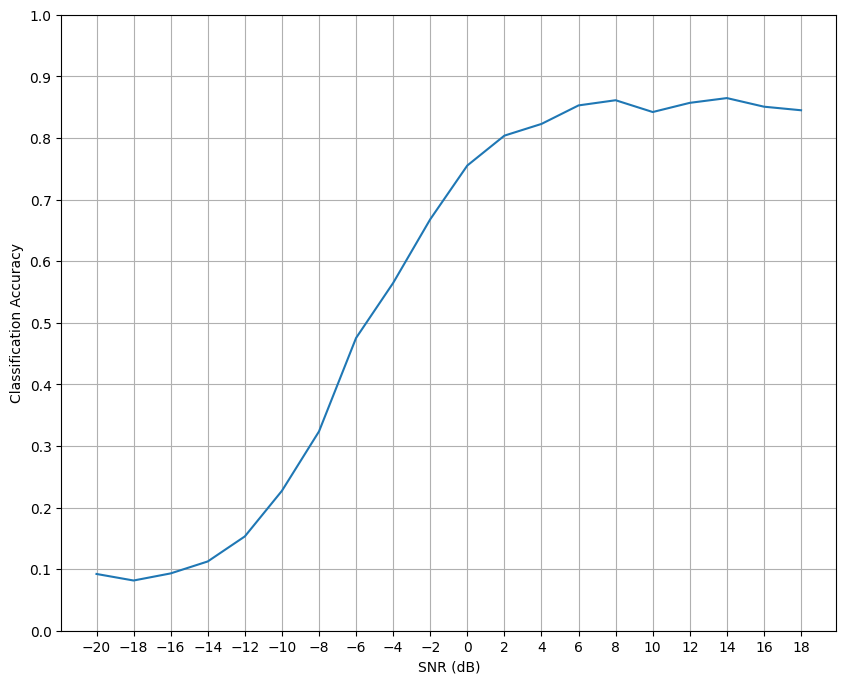

3/3 [==============================] - 0s 37ms/step


In [ ]:
newModel.load_weights(root_path + 'Parallel network weight/double CNN1/double_CNN-weights-22.hdf5')
double_CNN_model_evaluater = ModelEvaluater(newModel, [X_train2,X_ap_train2], y_train, [X_val2,X_ap_val2], y_val, [X_test2,X_ap_test2], y_test, labels_test, BATCH_SIZE, 'double_CNN' )
double_CNN_model_evaluater.print_summary()
double_CNN_accpersnr = double_CNN_model_evaluater.accpersnr_model()

In [ ]:
import joblib
data = joblib.load(root_path + 'Parallel network weight/data/rml_trainvaltest3.hdf5')

In [ ]:
EPOCHS = 100
NUM_CLASSES = 11
BATCH_SIZE = 1024 #time-series
PATIENCE = 10

In [ ]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
#ip--ap
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])#建立数组
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

In [ ]:
#设置混淆矩阵
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    #调制--索引
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size) #输入测试数据X,输出预测结果y_hat
    y_hat_onehot = np.zeros_like(y_hat) #其维度与矩阵y_hat一致，并为其初始化为全0
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels, rotation=45)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

In [ ]:
#created my own LabelBinarizer class so can encode both 2-class and multiclass cases
#建立分类函数
class MyLabelBinarizer(preprocessing.LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=2):
    # 如果通道在前，输入的类型不变
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + 'Parallel network weight/double CNN-LSTM2/%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = MyLabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
  
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    # 有出处
    snr_ranges = [(-20, 18), (-10, 5), (6, 18)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    # unique函数去除其中重复的元素，并按元素由大到小返回一个新的无元素重复的元组或者列表
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]

      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("SNR (dB)")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()

    # acc--snr曲线图函数
  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

    # 
  def confmat_snr(self, snr_rng):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

In [ ]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['train', 'val', 'test'])
Train val test size:  (147400, 2, 128) (28600, 2, 128) (44000, 2, 128)
Check if data is shuffled:  [['QAM64' '12']
 ['QAM64' '-20']
 ['QAM64' '-20']
 ['CPFSK' '12']
 ['WBFM' '18']
 ['AM-DSB' '-20']
 ['PAM4' '-12']
 ['QAM64' '-4']
 ['PAM4' '12']
 ['QAM64' '10']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [7327 7467 7344 7417 7402 7428 7457 7344 7335 7355 7362 7329 7315 7407
 7362 7366 7483 7278 7306 7316]
Check modulation types:  ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']
Check distribution of samples across modulation types:  [13447 13432 13547 13458 13375 13356 13336 13320 13329 13403 13397]


In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 
y_train = labels_train[:,0]

X_val = data['val']['X']
labels_val = data['val']['labels'] 
y_val = labels_val[:,0]

X_test = data['test']['X']
labels_test = data['test']['labels'] 
y_test = labels_test[:,0]

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

In [ ]:
dr = 0.5
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

input_x = Input(shape=(1, X_test.shape[1],X_test.shape[2]))

input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)
#layer1 = Dropout(dr)(layer1)
layer1 = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
#layer2 = Dropout(dr)(layer2)
layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv3", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
#layer3 = Dropout(dr)(layer3)

concat = layer3
#concat = keras.layers.concatenate([layer1, layer3])

concat_size = list(np.shape(concat))
input_dim = int(concat_size[-1] * concat_size[-2])
timesteps = int(concat_size[-3])
concat = Reshape((timesteps, input_dim))(concat)
LSTM_out = LSTM(50, activation='tanh', input_dim=input_dim, input_length=timesteps, return_sequences=True)(concat)
LSTM_out = Dropout(dr)(LSTM_out)
LSTM_out = LSTM(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(LSTM_out)
LSTM_out = Dropout(dr)(LSTM_out)
#mergedOut = Dropout(dr)(mergedOut)
#layer_dense1 = Dense(256, activation='selu', kernel_initializer='he_normal', name="dense101")(gru_out)

#gru_out = Dropout(dr)(gru_out)

LSTM_out = Reshape((1,50))(LSTM_out)

model1 = Model(inputs=input_x, outputs=LSTM_out)

model1.compile()

model1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 2, 128)]       0         
                                                                 
 zero_padding2d_18 (ZeroPadd  (None, 1, 2, 132)        0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 50, 2, 125)        450       
                                                                 
 zero_padding2d_19 (ZeroPadd  (None, 50, 2, 129)       0         
 ing2D)                                                          
                                                                 
 conv2 (Conv2D)              (None, 50, 2, 122)        20050     
                                                                 
 zero_padding2d_20 (ZeroPadd  (None, 50, 2, 126)       0  

In [ ]:
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])


input_x = Input(shape=(1, X_ap_test.shape[1], X_ap_test.shape[2]))

input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv21", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)

#layer1 = Dropout(dr)(layer1)
layer1 = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv22", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
#layer2 = Dropout(dr)(layer2)
layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv23", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
#layer3 = Dropout(dr)(layer3)

concat = layer3
#concat = keras.layers.concatenate([layer1, layer3])

concat_size = list(np.shape(concat))
input_dim = int(concat_size[-1] * concat_size[-2])
timesteps = int(concat_size[-3])
concat = Reshape((timesteps, input_dim))(concat)
LSTM_out = LSTM(50, activation='tanh', input_dim=input_dim, input_length=timesteps, return_sequences=True)(concat)
LSTM_out = Dropout(dr)(LSTM_out)
LSTM_out = LSTM(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(LSTM_out)
LSTM_out = Dropout(dr)(LSTM_out)
#mergedOut = Dropout(dr)(mergedOut)
#layer_dense1 = Dense(256, activation='selu', kernel_initializer='he_normal', name="dense101")(gru_out)

#gru_out = Dropout(dr)(gru_out)

LSTM_out = Reshape((50,1))(LSTM_out)

model2 = Model(inputs=input_x, outputs=LSTM_out)

model2.compile()

model2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 2, 128)]       0         
                                                                 
 zero_padding2d_21 (ZeroPadd  (None, 1, 2, 132)        0         
 ing2D)                                                          
                                                                 
 conv21 (Conv2D)             (None, 50, 2, 125)        450       
                                                                 
 zero_padding2d_22 (ZeroPadd  (None, 50, 2, 129)       0         
 ing2D)                                                          
                                                                 
 conv22 (Conv2D)             (None, 50, 2, 122)        20050     
                                                                 
 zero_padding2d_23 (ZeroPadd  (None, 50, 2, 126)       0  

In [ ]:
mergedOut = keras.layers.multiply([model1.output,model2.output]) 
# output layer
mergedOut = Flatten()(mergedOut)
mergedOut = Dropout(dr)(mergedOut)
#mergedOut = GRU(100, activation='tanh', input_dim=input_dim, input_length=timesteps, return_sequences=True)(mergedOut)
#mergedOut = Dropout(dr)(mergedOut)
#mergedOut = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(mergedOut)
#mergedOut = Dropout(dr)(mergedOut)
mergedOut = Dense(128, activation='relu')(mergedOut)
#mergedOut = Flatten()(mergedOut)
mergedOut = Dropout(dr)(mergedOut)
mergedOut = Dense(11, activation='softmax')(mergedOut)
newModel = Model([model1.input,model2.input], mergedOut)
#newModel.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(lr=0.00018),metrics=['accuracy'])
#newModel.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
newModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#optimizer = AdamW()
#newModel.compile(loss='categorical_crossentropy',optimizer=adamw, metrics=['accuracy'])
newModel.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 1, 2, 132)   0           ['input_7[0][0]']                
 2D)                                                                                              
                                                                                                  
 zero_padding2d_21 (ZeroPadding  (None, 1, 2, 132)   0           ['input_8[0][0]']         

In [ ]:
double_CNN_LSTM_model_evaluater = ModelEvaluater(newModel, [X_train2,X_ap_train2], y_train, [X_val2,X_ap_val2], y_val, [X_test2,X_ap_test2], y_test, labels_test, BATCH_SIZE, 'double_CNN-LSTM' )
double_CNN_LSTM_model_evaluater.fit(EPOCHS, patience=PATIENCE)
#double_CNN_LSTM_model_evaluater.print_summary()

y_train 147400
y_val 28600
y_test 44000
Epoch 1/100
144/144 [==============================] - ETA: 0s - loss: 2.2352 - accuracy: 0.1706
Epoch 1: val_loss improved from inf to 1.95099, saving model to /content/drive/My Drive/Parallel network weight/double CNN-LSTM2/double_CNN-LSTM-weights-1.hdf5
144/144 [==============================] - 26s 115ms/step - loss: 2.2352 - accuracy: 0.1706 - val_loss: 1.9510 - val_accuracy: 0.2834
Epoch 2/100
144/144 [==============================] - ETA: 0s - loss: 1.8293 - accuracy: 0.3135
Epoch 2: val_loss improved from 1.95099 to 1.60119, saving model to /content/drive/My Drive/Parallel network weight/double CNN-LSTM2/double_CNN-LSTM-weights-2.hdf5
144/144 [==============================] - 15s 103ms/step - loss: 1.8293 - accuracy: 0.3135 - val_loss: 1.6012 - val_accuracy: 0.4118
Epoch 3/100
144/144 [==============================] - ETA: 0s - loss: 1.5740 - accuracy: 0.4123
Epoch 3: val_loss improved from 1.60119 to 1.44530, saving model to /content/

y_train 147400
y_val 28600
y_test 44000


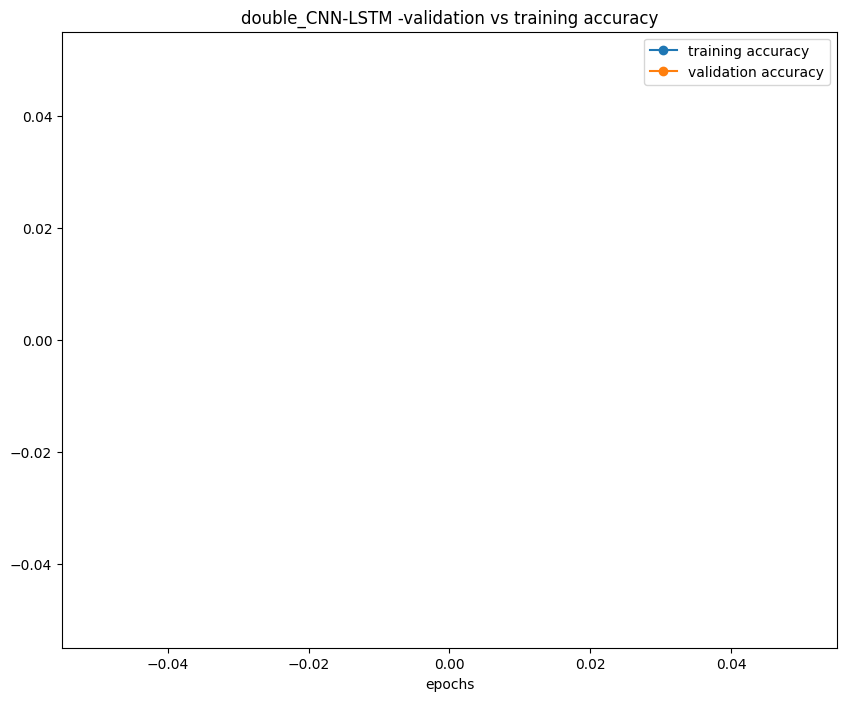

None

43/43 [==============================] - 3s 34ms/step


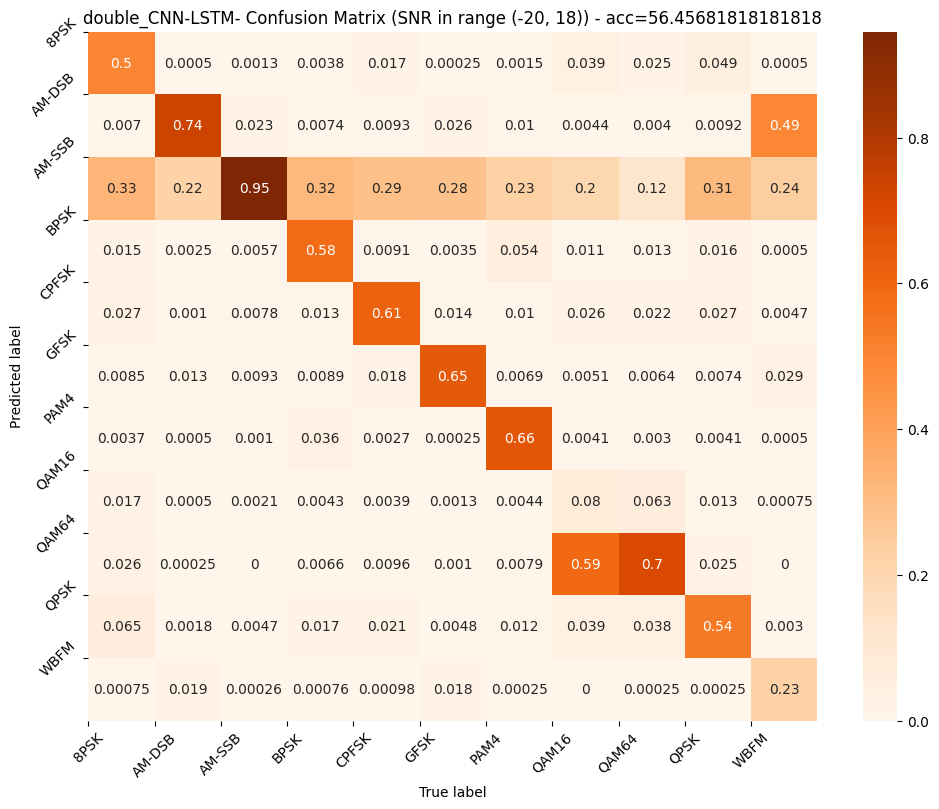

18/18 [==============================] - 1s 32ms/step


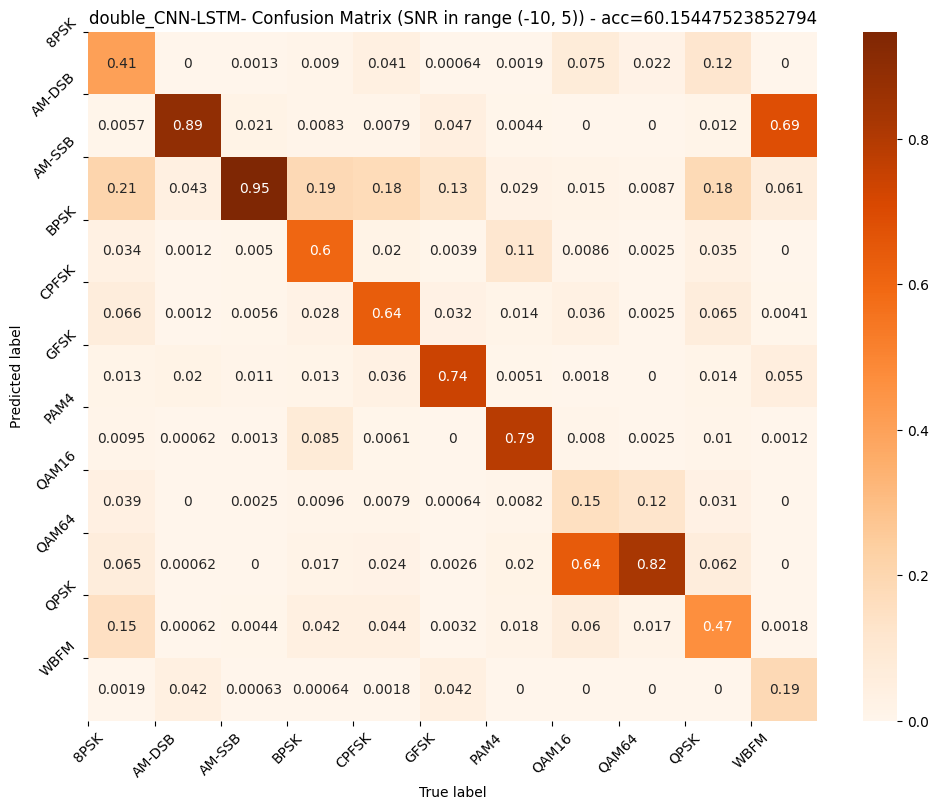

16/16 [==============================] - 0s 32ms/step


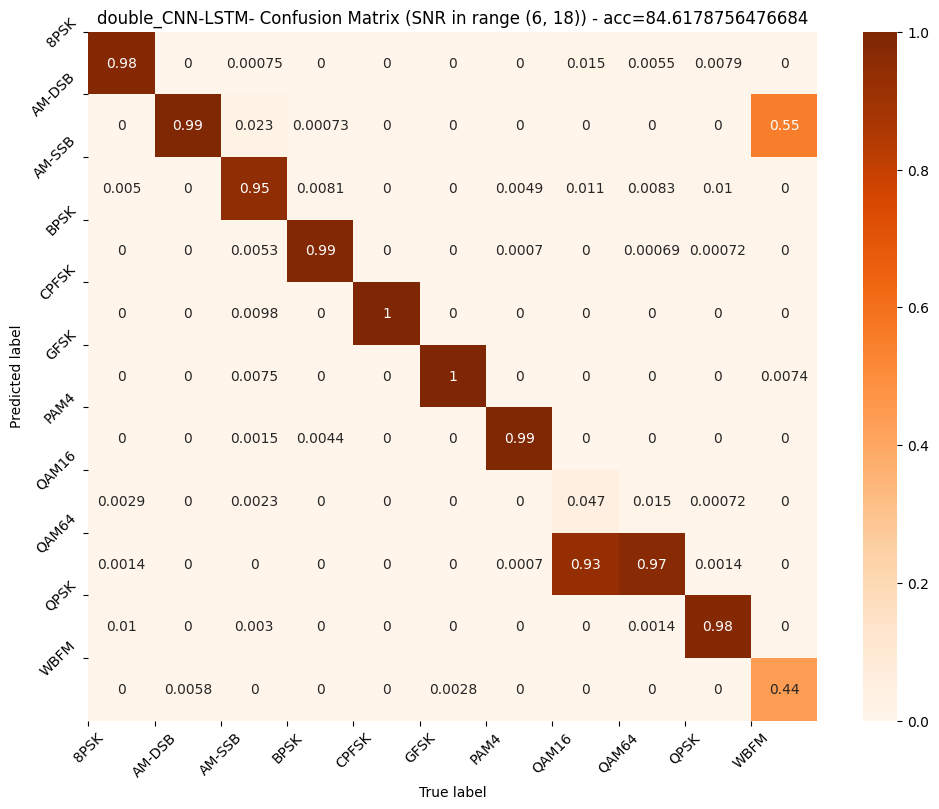

3/3 [==============================] - 0s 36ms/step


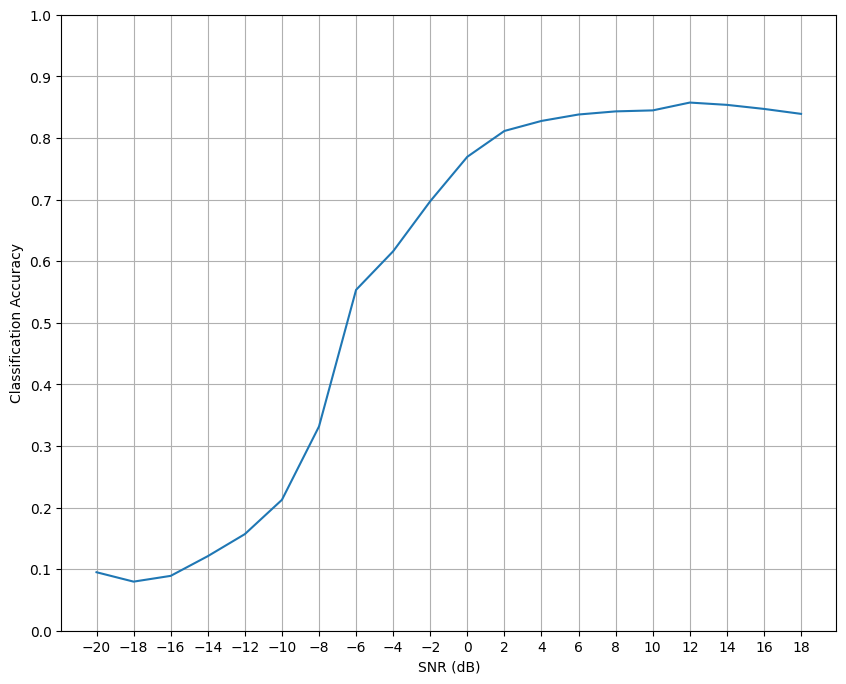

3/3 [==============================] - 0s 38ms/step


In [ ]:
newModel.load_weights(root_path + 'Parallel network weight/double CNN-LSTM2/double_CNN-LSTM-weights-27.hdf5')
double_CNN_LSTM_model_evaluater = ModelEvaluater(newModel, [X_train2,X_ap_train2], y_train, [X_val2,X_ap_val2], y_val, [X_test2,X_ap_test2], y_test, labels_test, BATCH_SIZE, 'double_CNN-LSTM' )
double_CNN_LSTM_model_evaluater.print_summary()
double_CNN_LSTM_accpersnr = double_CNN_LSTM_model_evaluater.accpersnr_model()

In [ ]:
def eca(inputs, b=1, gama=2):
 
 # 输入特征图的通道数
 in_channel = inputs.shape[-1]
 
 # 根据公式计算自适应卷积核大小
 kernel_size = int(abs((math.log(in_channel, 2) + b) / gama))
 
 # 如果卷积核大小是偶数，就使用它
 if kernel_size % 2:
  kernel_size = kernel_size
 
 # 如果卷积核大小是奇数就变成偶数
 else:
  kernel_size = kernel_size + 1
 
 # [h,w,c]==>[None,c] 全局平均池化
 x = keras.layers.GlobalAveragePooling2D()(inputs)
 
 # [None,c]==>[c,1]
 x = keras.layers.Reshape(target_shape=(in_channel, 1))(x)
 
 # [c,1]==>[c,1]
 x = keras.layers.Conv1D(filters=1, kernel_size=kernel_size, padding='same', use_bias=False)(x)
 
 # sigmoid激活
 x = keras.layers.Activation('sigmoid')(x)
 
 # [c,1]==>[1,1,c]
 x = keras.layers.Reshape((1,1,in_channel))(x)
 
 # 结果和输入相乘
 outputs = keras.layers.multiply([inputs, x])
 
 return outputs

In [ ]:
dr = 0.5
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

input_x = Input(shape=(1, X_test.shape[1],X_test.shape[2]))

#input_x = senet(input_x)
#x = eca(input_x)

input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)
#layer1 = senet(layer1)
#layer1 = eca(layer1)
#layer1 = coordinate(layer1)
#layer1 = CBAM(layer1)
#layer1 = Dropout(dr)(layer1)
layer1 = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
#layer2 = Dropout(dr)(layer2)
layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv3", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
#layer3 = Dropout(dr)(layer3)

#concat = layer3

concat = keras.layers.concatenate([layer1, layer3])

concat = eca(concat)
#concat = senet(concat)
#concat = coordinate(concat)
#concat = CBAM(concat)

concat_size = list(np.shape(concat))
input_dim = int(concat_size[-1] * concat_size[-2])
timesteps = int(concat_size[-3])
concat = Reshape((timesteps, input_dim))(concat)

#gru_out = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(concat)
#LSTM_out = LSTM(50, activation='tanh', input_dim=input_dim, input_length=timesteps, return_sequences=True)(concat)
#layer_dense1 = Dense(256, activation='selu', kernel_initializer='he_normal', name="dense101")(gru_out)

#gru_out = Dropout(dr)(gru_out)

#LSTM_out = Reshape((1,50))(LSTM_out)

model1 = Model(inputs=input_x, outputs=concat)

model1.compile()

model1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 1, 2, 132)   0           ['input_5[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 2, 125)   450         ['zero_padding2d_12[0][0]']      
                                                                                                  
 zero_padding2d_13 (ZeroPadding  (None, 50, 2, 129)  0           ['conv1[0][0]']            

In [ ]:
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])


input_x = Input(shape=(1, X_ap_test.shape[1], X_ap_test.shape[2]))

#input_x = senet(input_x)
#x = eca(input_x)

input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv21", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)
#layer1 = senet(layer1)
#layer1 = eca(layer1)
#layer1 = coordinate2(layer1)
#layer1 = CBAM(layer1)
#layer1 = Dropout(dr)(layer1)
layer1 = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv22", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
#layer2 = Dropout(dr)(layer2)
layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv23", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
#layer3 = Dropout(dr)(layer3)

#concat = layer3

concat = keras.layers.concatenate([layer1, layer3])

concat = eca(concat)
#concat = senet(concat)
#concat = coordinate2(concat)
#concat = CBAM(concat)

concat_size = list(np.shape(concat))
input_dim = int(concat_size[-1] * concat_size[-2])
timesteps = int(concat_size[-3])
concat = Reshape((timesteps, input_dim))(concat)
#gru_out = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(concat)
#layer_dense1 = Dense(256, activation='selu', kernel_initializer='he_normal', name="dense101")(gru_out)
#LSTM_out = LSTM(50, activation='tanh', input_dim=input_dim, input_length=timesteps, return_sequences=True)(concat)
#gru_out = Dropout(dr)(gru_out)

#LSTM_out = Reshape((50,1))(LSTM_out)

model2 = Model(inputs=input_x, outputs=concat)

model2.compile()

model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_15 (ZeroPadding  (None, 1, 2, 132)   0           ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv21 (Conv2D)                (None, 50, 2, 125)   450         ['zero_padding2d_15[0][0]']      
                                                                                                  
 zero_padding2d_16 (ZeroPadding  (None, 50, 2, 129)  0           ['conv21[0][0]']           

In [ ]:
mergedOut = keras.layers.concatenate([model1.output,model2.output]) 
# output layer
#mergedOut = Flatten()(mergedOut)
#mergedOut = Reshape((50,1))(mergedOut)
mergedOut = Dropout(dr)(mergedOut)
#mergedOut = GRU(100, activation='tanh', input_dim=input_dim, input_length=timesteps, return_sequences=True)(mergedOut)
#mergedOut = Dropout(dr)(mergedOut)
mergedOut = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps, return_sequences=True)(mergedOut)
#mergedOut = Flatten()(mergedOut)
mergedOut = Dropout(dr)(mergedOut)
#mergedOut = Dense(128, activation='selu')(mergedOut)
mergedOut = Flatten()(mergedOut)
mergedOut = Dropout(dr)(mergedOut)
mergedOut = Dense(11, activation='softmax')(mergedOut)
newModel = Model([model1.input,model2.input], mergedOut)
#newModel.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(lr=0.00018),metrics=['accuracy'])
#newModel.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
newModel.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#optimizer = AdamW()
#newModel.compile(loss='categorical_crossentropy',optimizer=adamw, metrics=['accuracy'])
newModel.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 1, 2, 132)   0           ['input_5[0][0]']                
 2D)                                                                                              
                                                                                                  
 zero_padding2d_15 (ZeroPadding  (None, 1, 2, 132)   0           ['input_6[0][0]']          

y_train 147400
y_val 28600
y_test 44000


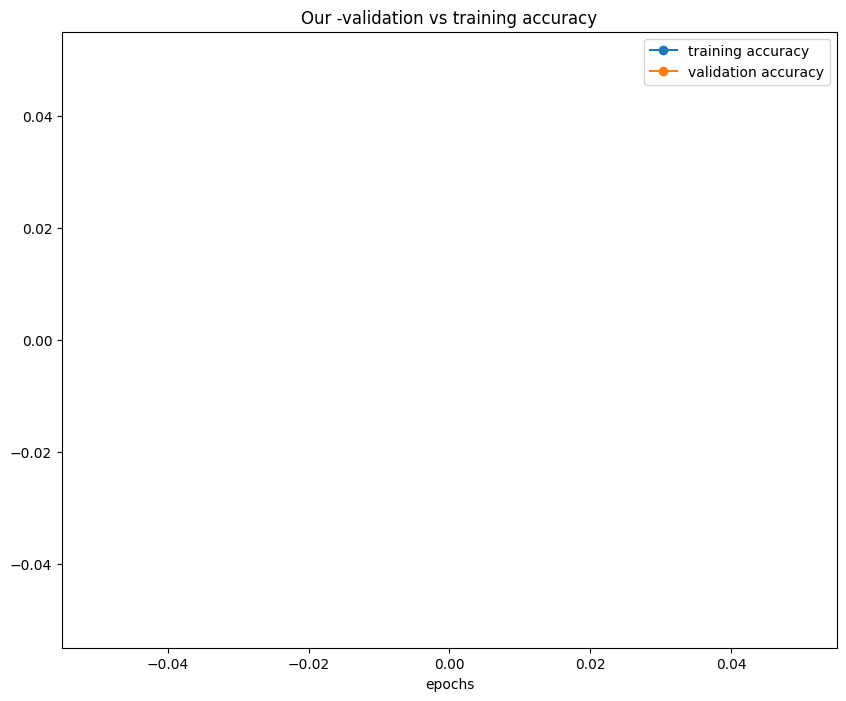

None

43/43 [==============================] - 4s 58ms/step


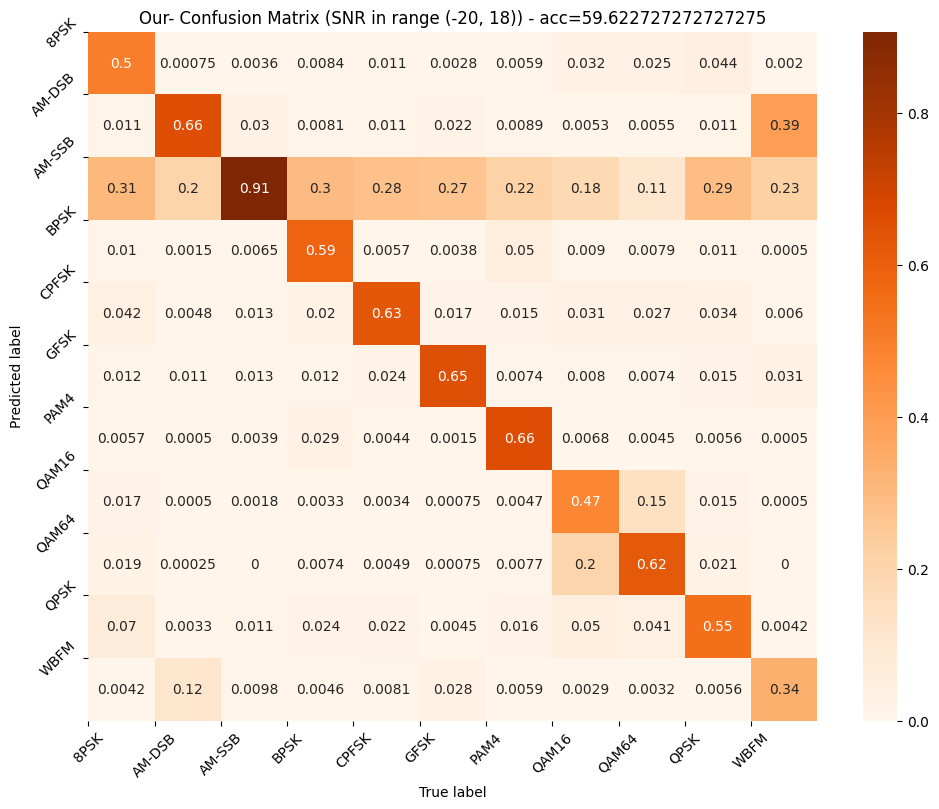

18/18 [==============================] - 1s 78ms/step


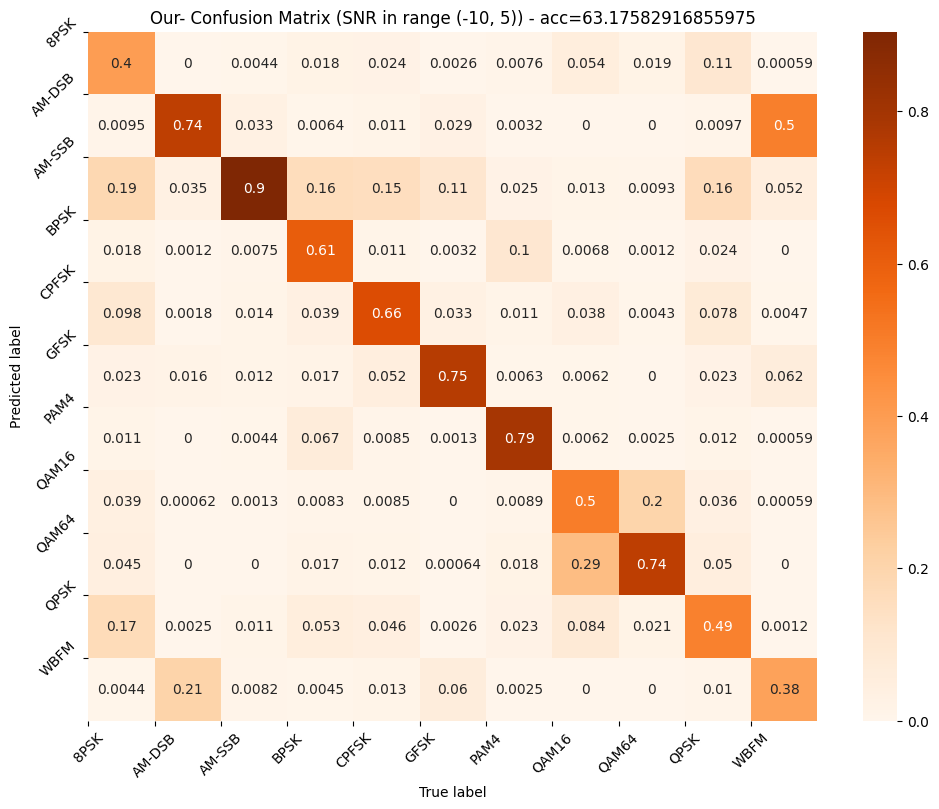

16/16 [==============================] - 1s 66ms/step


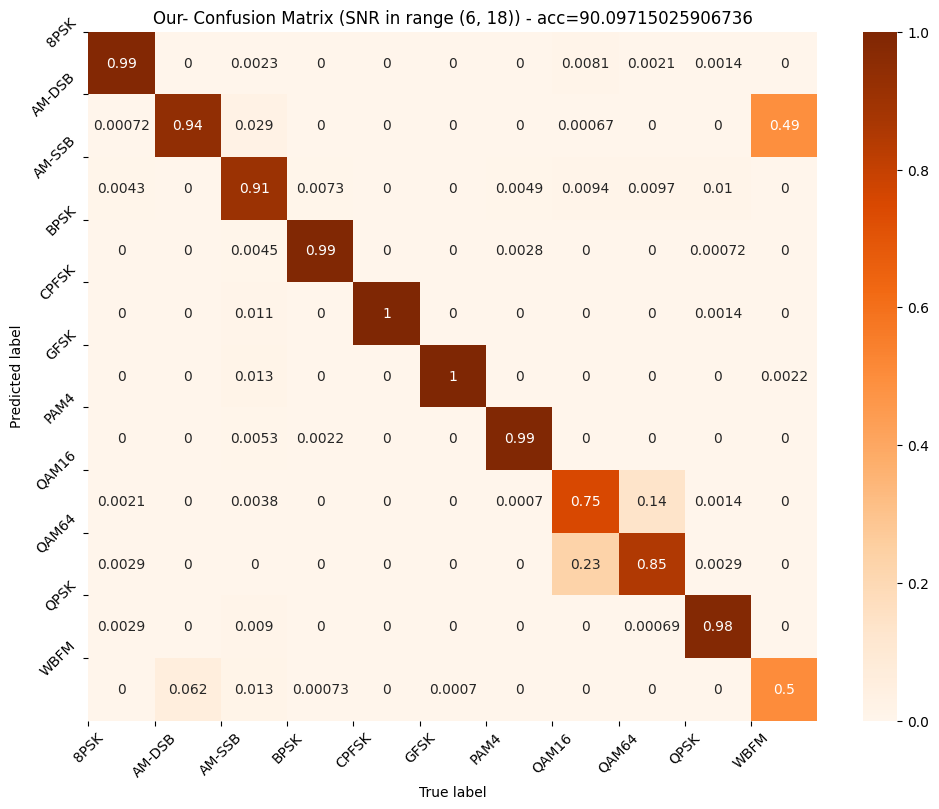

3/3 [==============================] - 1s 356ms/step


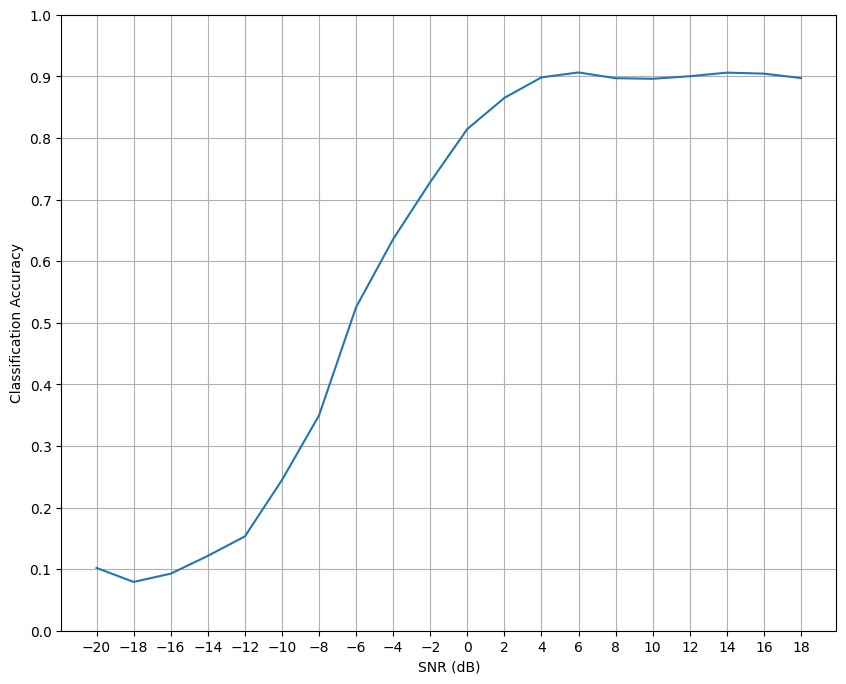

3/3 [==============================] - 0s 38ms/step


In [ ]:
newModel.load_weights(root_path + 'Parallel network weight/our2/Our-weights-14.hdf5')
newModel_evaluater = ModelEvaluater(newModel, [X_train2,X_ap_train2], y_train, [X_val2,X_ap_val2], y_val, [X_test2,X_ap_test2], y_test, labels_test, BATCH_SIZE, 'Our' )
newModel_evaluater.print_summary()
our_accpersnr = newModel_evaluater.accpersnr_model()

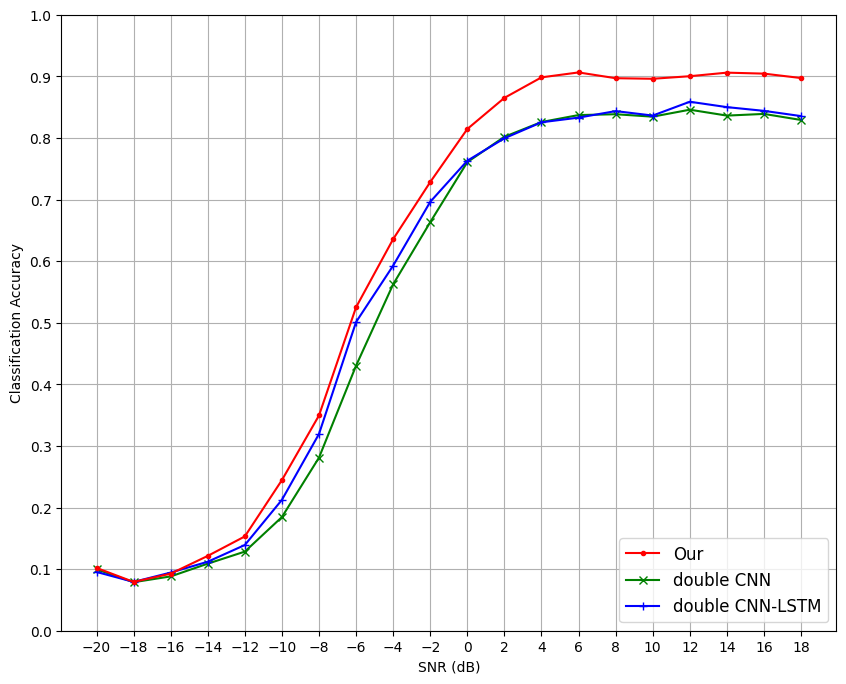

In [ ]:
# plot acc-vs-snr graphs for different models
double_CNN,  = plt.plot(list(double_CNN_accpersnr.keys()),list(double_CNN_accpersnr.values()), 'gx-', label='double CNN')
#inception, = plt.plot(list(Inception_accpersnr.keys()),list(Inception_accpersnr.values()), 'c2-', label='Inception_IQ')
#lstm, = plt.plot(list(lstm_accpersnr.keys()),list(lstm_accpersnr.values()), 'y3-', label='LSTM_IQ')
#cldnn, = plt.plot(list(cldnn_accpersnr.keys()),list(cldnn_accpersnr.values()), 'g+-', label='CLDNN_IQ')
#cgdnn, = plt.plot(list(cgdnn_accpersnr.keys()),list(cgdnn_accpersnr.values()), 'bx-', label='CGDNN_IQ')

double_CNN_LSTM,  = plt.plot(list(double_CNN_LSTM_accpersnr.keys()),list(double_CNN_LSTM_accpersnr.values()), 'b+-', label='double CNN-LSTM')
#inception_ap, = plt.plot(list(Inception_ap_accpersnr.keys()),list(Inception_ap_accpersnr.values()), 'c2:', label='Inception_AP')
#lstm_ap, = plt.plot(list(lstm_ap_accpersnr.keys()),list(lstm_ap_accpersnr.values()), 'y3:', label='LSTM_AP')
#cldnn_ap, = plt.plot(list(cldnn_ap_accpersnr.keys()),list(cldnn_ap_accpersnr.values()), 'g+:', label='CLDNN_AP')
#cgdnn_ap, = plt.plot(list(cgdnn_ap_accpersnr.keys()),list(cgdnn_ap_accpersnr.values()), 'bx:', label='CGDNN_AP')

our,  = plt.plot(list(our_accpersnr.keys()),list(our_accpersnr.values()), 'r.-', label='Our')

plt.xlabel("SNR (dB)")
plt.ylabel("Classification Accuracy")
plt.xticks(list(our_accpersnr.keys()))
plt.legend(handles = [our, double_CNN, double_CNN_LSTM], loc="lower right", prop = {'size':12})
#plt.legend(handles = [cnn, inception, lstm, cldnn, cnn_ap, inception_ap, lstm_ap, cldnn_ap], loc="lower right", prop = {'size':12})
#plt.legend(loc="lower right")
#plt.legend(prop = {'size':8})
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()